# BLE Proximity Experiment - Multi-Layered Perceptron Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../dataset_train_university.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,4.5,-86,-86.000000,Public,4.5
1,0.0,4.5,-84,-85.000000,Public,4.5
2,0.0,4.5,-83,-84.333333,Public,4.5
3,0.0,4.5,-84,-84.250000,Public,4.5
4,0.0,4.5,-92,-85.800000,Public,4.5
...,...,...,...,...,...,...
3672,0.0,0.0,-57,-56.814815,Personal,0.0
3673,0.0,0.0,-56,-56.785714,Personal,0.0
3674,0.0,0.0,-56,-56.758621,Personal,0.0
3675,0.0,0.0,-56,-56.733333,Personal,0.0


(3677, 6)

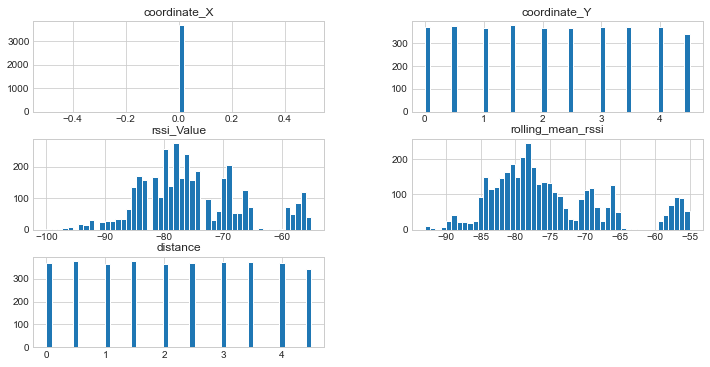

In [5]:
test_dataset = load_file('../../dataset_test_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | BIG DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,Personal,0.0
1,0.0,0.0,-46,-46.500000,Personal,0.0
2,0.0,0.0,-46,-46.333333,Personal,0.0
3,0.0,0.0,-47,-46.500000,Personal,0.0
4,0.0,0.0,-47,-46.600000,Personal,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,Social,3.5
12471,0.0,3.5,-87,-84.684211,Social,3.5
12472,0.0,3.5,-87,-84.800000,Social,3.5
12473,0.0,3.5,-87,-84.904762,Social,3.5


(12475, 6)

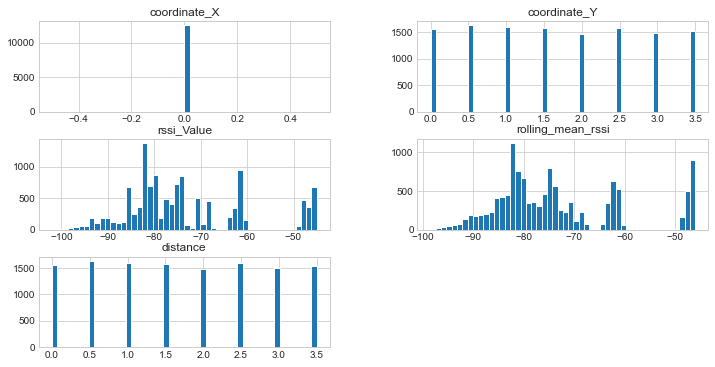

In [6]:
test_dataset_home_big = load_file('../../dataset_test_home_big.csv')
positions = test_dataset_home_big['coordinate_Y']
test_dataset_home_big['distance'] = positions
replace_features_nan(test_dataset_home_big)
display(test_dataset_home_big)
display(test_dataset_home_big.shape)
test_dataset_home_big.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,Personal,0.0
1,0.0,0.0,-44,-44.000000,Personal,0.0
2,0.0,0.0,-44,-44.000000,Personal,0.0
3,0.0,0.0,-44,-44.000000,Personal,0.0
4,0.0,0.0,-45,-44.200000,Personal,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,Social,3.5
2280,0.0,3.5,-85,-84.000000,Social,3.5
2281,0.0,3.5,-85,-84.050000,Social,3.5
2282,0.0,3.5,-92,-84.428571,Social,3.5


(2284, 6)

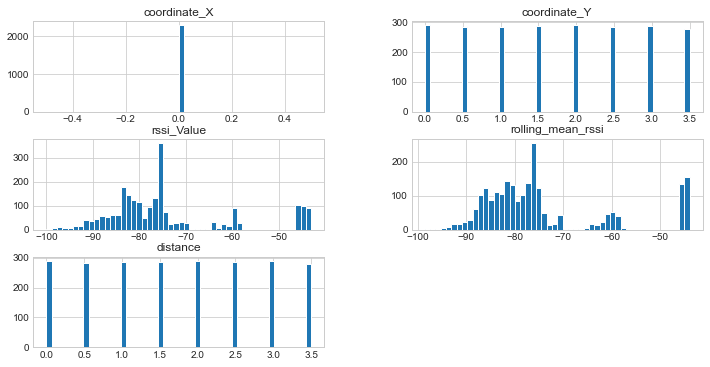

In [7]:
test_dataset_home_small = load_file('../../dataset_test_home.csv')
positions = test_dataset_home_small['coordinate_Y']
test_dataset_home_small['distance'] = positions
replace_features_nan(test_dataset_home_small)
display(test_dataset_home_small)
display(test_dataset_home_small.shape)
test_dataset_home_small.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET ASUS)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,Personal,0.0
1,0.0,0.0,-50,-50.000000,Personal,0.0
2,0.0,0.0,-53,-51.000000,Personal,0.0
3,0.0,0.0,-51,-51.000000,Personal,0.0
4,0.0,0.0,-53,-53.000000,Personal,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,Social,3.5
411,0.0,3.5,-88,-84.500000,Social,3.5
412,0.0,3.5,-84,-84.428571,Social,3.5
413,0.0,3.5,-83,-84.250000,Social,3.5


(415, 6)

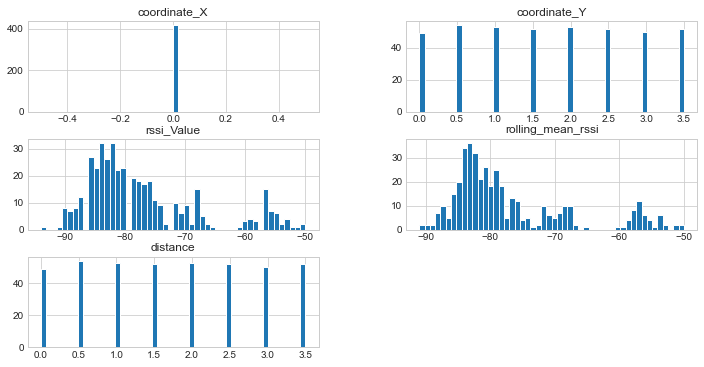

In [8]:
test_dataset_home_asus = load_file('../../dataset_test_home_asus.csv')
positions = test_dataset_home_asus['coordinate_Y']
test_dataset_home_asus['distance'] = positions
replace_features_nan(test_dataset_home_asus)
display(test_dataset_home_asus)
display(test_dataset_home_asus.shape)
test_dataset_home_asus.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [9]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24834 entries, 0 to 24833
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       24834 non-null  float64
 1   coordinate_Y       24834 non-null  float64
 2   rssi_Value         24834 non-null  int64  
 3   rolling_mean_rssi  24834 non-null  float64
 4   zone               24834 non-null  object 
 5   distance           24834 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,24834.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
coordinate_Y,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5
rssi_Value,24834.0,-76.687243,11.255077,-102.0,-84.000000,-78.0,-73.000000,-46.0
rolling_mean_rssi,24834.0,-76.677952,10.969519,-99.0,-83.666667,-78.5,-73.767308,-46.0
distance,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5


### % of Missing Values

In [11]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [12]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

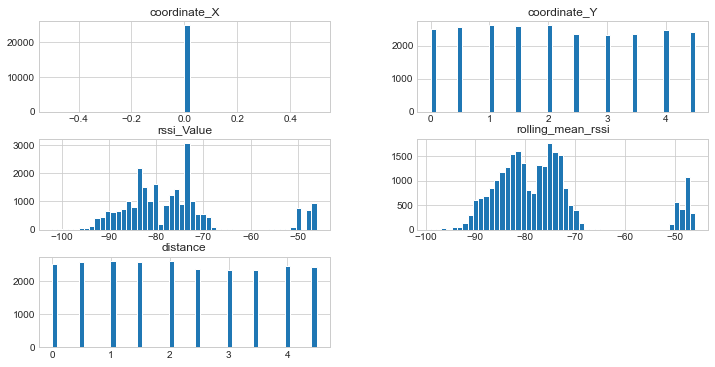

In [13]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

<AxesSubplot:xlabel='zone'>

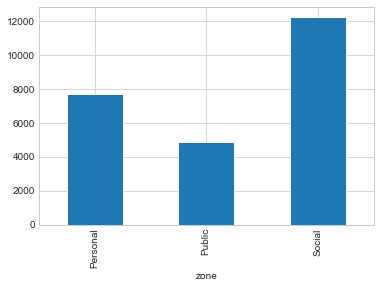

In [14]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

<AxesSubplot:xlabel='zone,distance'>

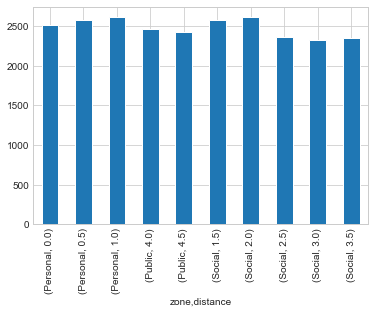

In [15]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

C:\DevelopmentTools\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


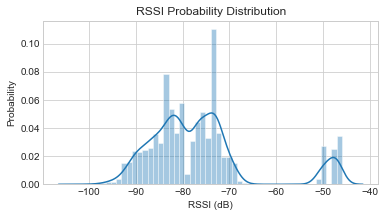

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

C:\DevelopmentTools\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


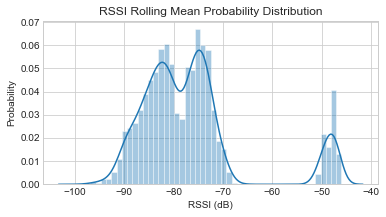

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

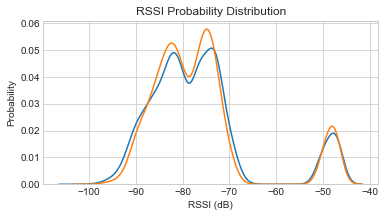

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


coordinate_Y         1.000000
distance             1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

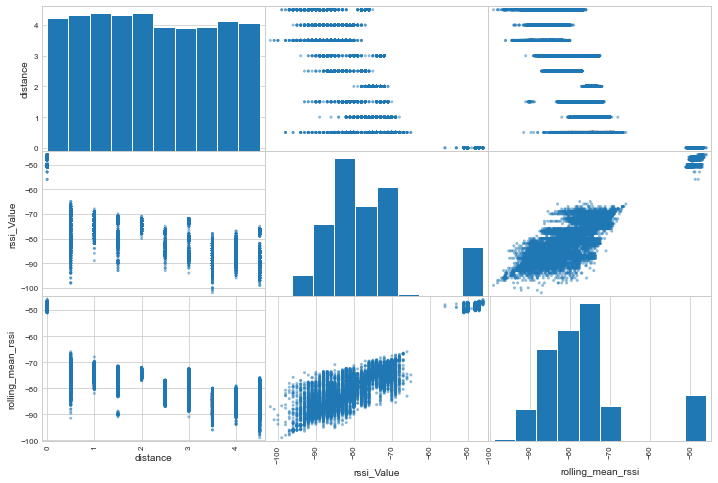

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_big,'rssi_Value')
compute_data_cleaning(test_dataset_home_big,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_small,'rssi_Value')
compute_data_cleaning(test_dataset_home_small,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_asus,'rssi_Value')
compute_data_cleaning(test_dataset_home_asus,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [23]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [24]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [25]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,Public
1,Public
2,Public
3,Public
4,Public
...,...
3672,Personal
3673,Personal
3674,Personal
3675,Personal


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(3677, 1)

In [26]:
categorical_zone = test_dataset_home_big[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_big['labels'] = test_changed
test_Y_home_big = test_dataset_home_big['labels'].values.reshape(-1,1)
display(test_Y_home_big.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
12470,Social
12471,Social
12472,Social
12473,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(12475, 1)

In [27]:
categorical_zone = test_dataset_home_small[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_small['labels'] = test_changed
test_Y_home_small = test_dataset_home_small['labels'].values.reshape(-1,1)
display(test_Y_home_small.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
2279,Social
2280,Social
2281,Social
2282,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(2284, 1)

In [28]:
categorical_zone = test_dataset_home_asus[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_asus['labels'] = test_changed
test_Y_home_asus = test_dataset_home_asus['labels'].values.reshape(-1,1)
display(test_Y_home_asus.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
410,Social
411,Social
412,Social
413,Social


After One Hot Encoder


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(415, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [29]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(24834, 1)

(24834, 1)

(24834, 2)

In [30]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.101350,-66.075278
Public,-84.953374,-84.856790
Social,-80.050008,-80.086162


### Plot Training Data
Graphical Display of the observations in the dataset

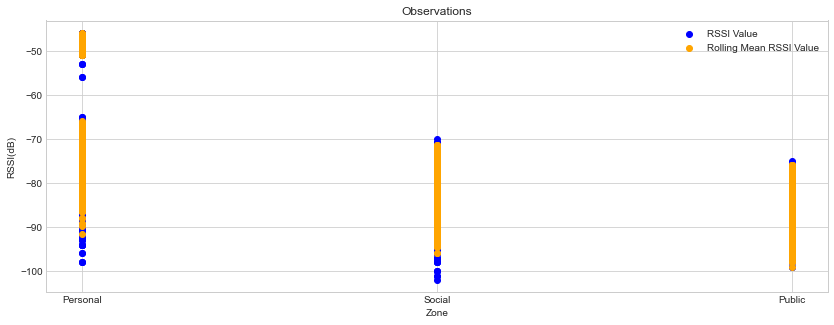

In [31]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [32]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(3677, 1)

(3677, 1)

(3677, 2)

In [33]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.634563,-66.593533
Public,-81.438819,-81.521907
Social,-78.235580,-78.069045


In [34]:
test_X_rssi_home_big = pd.DataFrame(test_dataset_home_big['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_big.shape)
test_X_rolling_mean_home_big = pd.DataFrame(test_dataset_home_big['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_big.shape)
test_combination_features_X_home_big = test_dataset_home_big[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_big.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [35]:
data_plot_means = test_dataset_home_big.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-60.626277,-60.688594
Social,-81.402474,-81.424138


In [36]:
test_X_rssi_home_small = pd.DataFrame(test_dataset_home_small['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_small.shape)
test_X_rolling_mean_home_small = pd.DataFrame(test_dataset_home_small['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_small.shape)
test_combination_features_X_home_small = test_dataset_home_small[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_small.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [37]:
data_plot_means = test_dataset_home_small.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-63.987165,-64.275969
Social,-80.535389,-80.579521


In [38]:
test_X_rssi_home_asus = pd.DataFrame(test_dataset_home_asus['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_asus.shape)
test_X_rolling_mean_home_asus = pd.DataFrame(test_dataset_home_asus['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_asus.shape)
test_combination_features_X_home_asus = test_dataset_home_asus[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_asus.shape)

(415, 1)

(415, 1)

(415, 2)

In [39]:
data_plot_means = test_dataset_home_asus.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-69.205128,-69.220368
Social,-82.181467,-82.010114


### Plot Test Data

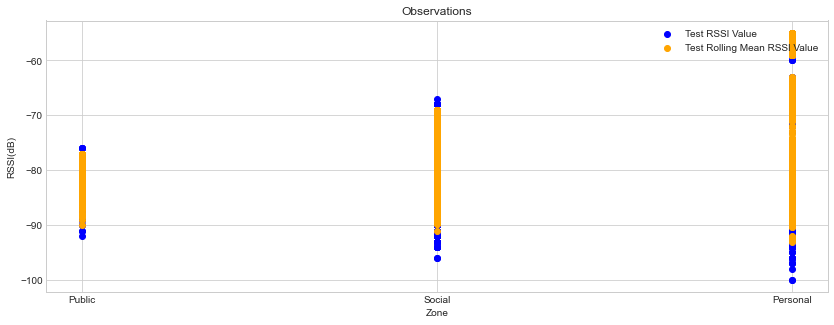

In [40]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

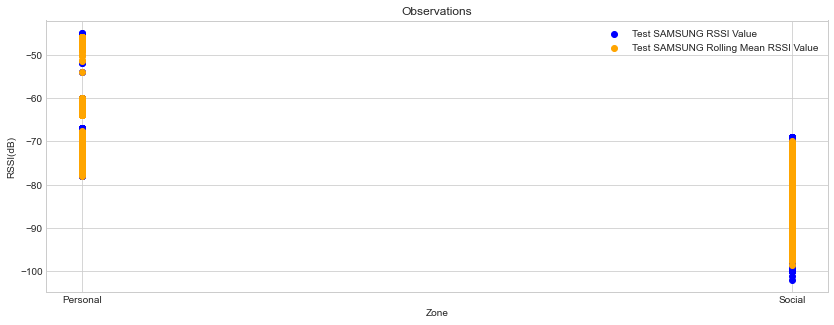

In [41]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

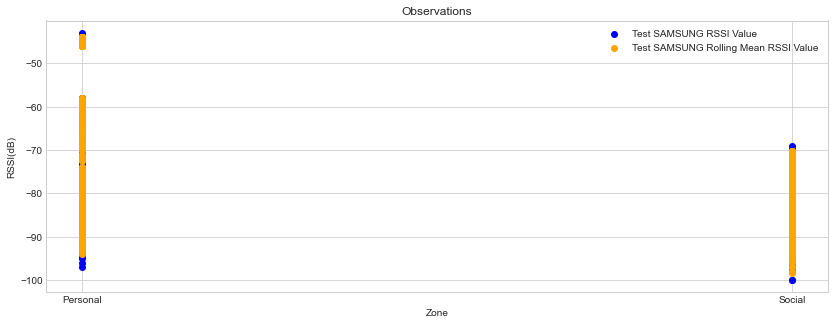

In [42]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

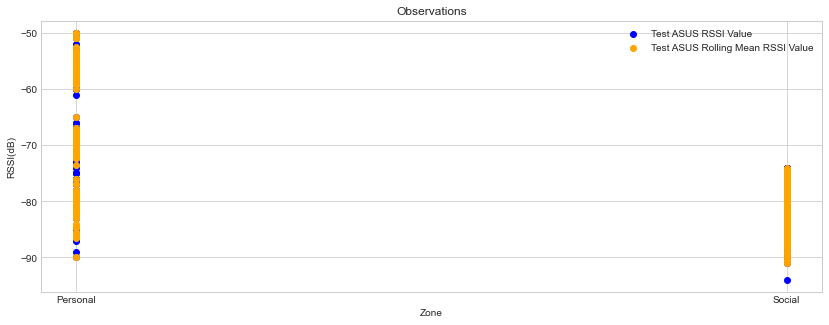

In [43]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rssi_Value'],label='Test ASUS RSSI Value',color='blue')
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rolling_mean_rssi'],label='Test ASUS Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [44]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Batch size of samples
batch_size = [10, 20, 40, 60, 80, 100]
# Epochs 
epochs = [10, 50, 100]
# Optimization function
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# Learning Rate - only used with SGD optimizer
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# Momentum - only used with SGD optimizer
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# Number of neurons in a hidden layer
neurons = [100,300,400,500,600]

### Statistics Output Format

In [45]:
def structure_data(data,precision,accuracy,f1score, statistics=None):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    if statistics is not None:
        micro = [statistics.loc['accuracy','precision'], statistics.loc['accuracy','recall'], statistics.loc['accuracy','f1-score']] if 'accuracy' in statistics.index else [statistics.loc['micro avg','precision'],statistics.loc['micro avg','recall'], statistics.loc['micro avg','f1-score']]
        macro = [statistics.loc['macro avg','precision'], statistics.loc['macro avg','recall'], statistics.loc['macro avg','f1-score']]
        weighted = [statistics.loc['weighted avg','precision'], statistics.loc['weighted avg','recall'], statistics.loc['weighted avg','f1-score']]
        return statistical_results + micro + macro + weighted
    else:
        return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.37038858, 0.62961142])

rolling_mean_rssi    0.629611
rssi_Value           0.370389
dtype: float64

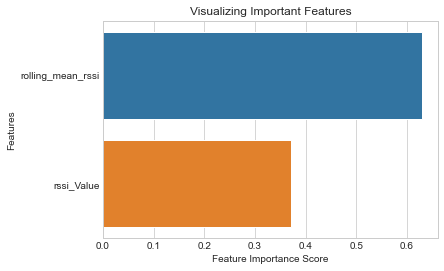

In [46]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - MLP Classification Model
Experiments with MLP algorithm

In [47]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 180
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 180)               540       
_________________________________________________________________
dense_1 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

In [48]:
def compute_MLP_Classifier(flag=0,dim=2,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,batch_size=10,epochs=50,verbose=0,num_neurons_param=180,optimizer_func='adam',activation_func='relu'):
    keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,epochs=epochs,num_neurons=num_neurons_param,optimizer=optimizer_func,activation=activation_func,batch_size=batch_size,verbose=verbose)
    seed = 7
    np.random.seed(seed)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,keras_classification_model)
    else:
        main_estimator = keras_classification_model
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        print("Cross Validation Activated. CV = " + str(cross_validation))
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(dataset.zone,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)

#### Check Training model with no cross validation

Epoch 1/50
2484/2484 [==============================] - 2s 975us/step - loss: 0.7068 - accuracy: 0.66150s - loss: 0
Epoch 2/50
2484/2484 [==============================] - 2s 929us/step - loss: 0.6650 - accuracy: 0.6856
Epoch 3/50
2484/2484 [==============================] - 2s 951us/step - loss: 0.6535 - accuracy: 0.6984
Epoch 4/50
2484/2484 [==============================] - 2s 977us/step - loss: 0.6462 - accuracy: 0.7027
Epoch 5/50
2484/2484 [==============================] - 2s 901us/step - loss: 0.6443 - accuracy: 0.7062
Epoch 6/50
2484/2484 [==============================] - 2s 896us/step - loss: 0.6408 - accuracy: 0.7058
Epoch 7/50
2484/2484 [==============================] - 2s 899us/step - loss: 0.6399 - accuracy: 0.7085
Epoch 8/50
2484/2484 [==============================] - 2s 919us/step - loss: 0.6385 - accuracy: 0.7107
Epoch 9/50
2484/2484 [==============================] - 2s 972us/step - loss: 0.6374 - accuracy: 0.7114
Epoch 10/50
2484/2484 [=============================

,precision,recall,f1-score,support
0,0.863317,0.718012,0.783989,7706.000000
1,0.569088,0.426176,0.487371,4890.000000
2,0.690442,0.832898,0.755009,12238.000000
accuracy,0.717162,0.717162,0.717162,0.717162
macro avg,0.707616,0.659028,0.675456,24834.000000
weighted avg,0.720190,0.717162,0.711302,24834.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,1
24830,1,1
24831,1,1
24832,1,1


Epoch 1/50
2484/2484 [==============================] - 2s 742us/step - loss: 0.6935 - accuracy: 0.64540s - loss: 0.703
Epoch 2/50
2484/2484 [==============================] - 2s 761us/step - loss: 0.6686 - accuracy: 0.6485
Epoch 3/50
2484/2484 [==============================] - 2s 736us/step - loss: 0.6632 - accuracy: 0.6543
Epoch 4/50
2484/2484 [==============================] - 2s 723us/step - loss: 0.6605 - accuracy: 0.6557
Epoch 5/50
2484/2484 [==============================] - 2s 736us/step - loss: 0.6575 - accuracy: 0.6581
Epoch 6/50
2484/2484 [==============================] - 2s 711us/step - loss: 0.6544 - accuracy: 0.6564
Epoch 7/50
2484/2484 [==============================] - 2s 704us/step - loss: 0.6542 - accuracy: 0.6566
Epoch 8/50
2484/2484 [==============================] - 2s 685us/step - loss: 0.6524 - accuracy: 0.6627
Epoch 9/50
2484/2484 [==============================] - 2s 843us/step - loss: 0.6519 - accuracy: 0.6628
Epoch 10/50
2484/2484 [=========================

,precision,recall,f1-score,support
0,0.758197,0.681158,0.717616,7706.000000
1,0.576859,0.353783,0.438585,4890.000000
2,0.639284,0.778967,0.702247,12238.000000
accuracy,0.664895,0.664895,0.664895,0.664895
macro avg,0.658113,0.604636,0.619483,24834.000000
weighted avg,0.663891,0.664895,0.655099,24834.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,1
24830,1,1
24831,1,1
24832,1,1


Epoch 1/50
2484/2484 [==============================] - 2s 811us/step - loss: 0.6327 - accuracy: 0.6883
Epoch 2/50
2484/2484 [==============================] - 2s 786us/step - loss: 0.5696 - accuracy: 0.7270
Epoch 3/50
2484/2484 [==============================] - 2s 805us/step - loss: 0.5524 - accuracy: 0.7418
Epoch 4/50
2484/2484 [==============================] - 2s 799us/step - loss: 0.5401 - accuracy: 0.7503
Epoch 5/50
2484/2484 [==============================] - 2s 786us/step - loss: 0.5296 - accuracy: 0.7571
Epoch 6/50
2484/2484 [==============================] - 2s 792us/step - loss: 0.5236 - accuracy: 0.76130s - loss: 0
Epoch 7/50
2484/2484 [==============================] - 2s 761us/step - loss: 0.5209 - accuracy: 0.7631
Epoch 8/50
2484/2484 [==============================] - 2s 767us/step - loss: 0.5160 - accuracy: 0.7643
Epoch 9/50
2484/2484 [==============================] - 2s 780us/step - loss: 0.5125 - accuracy: 0.7662
Epoch 10/50
2484/2484 [=============================

,precision,recall,f1-score,support
0,0.896206,0.812354,0.852222,7706.00000
1,0.652016,0.661350,0.656650,4890.00000
2,0.778183,0.819578,0.798344,12238.00000
accuracy,0.786180,0.786180,0.786180,0.78618
macro avg,0.775468,0.764427,0.769072,24834.00000
weighted avg,0.789962,0.786180,0.787162,24834.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,1
24830,1,2
24831,1,1
24832,1,1


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type
2,0.213820,0.213820,0.462406,0.779669,0.786180,0.774939,0.786180,0.786180,0.786180,0.775468,0.764427,0.769072,0.789962,0.786180,0.787162,Both
0,0.282838,0.282838,0.531825,0.711303,0.717162,0.688382,0.717162,0.717162,0.717162,0.707616,0.659028,0.675456,0.720190,0.717162,0.711302,RSSI Only
1,0.335105,0.335105,0.578883,0.660207,0.664895,0.632987,0.664895,0.664895,0.664895,0.658113,0.604636,0.619483,0.663891,0.664895,0.655099,Rolling Mean RSSI


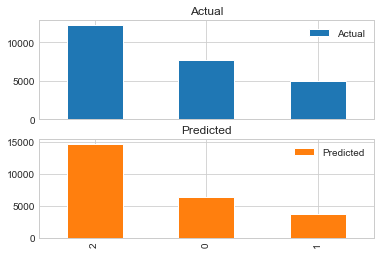

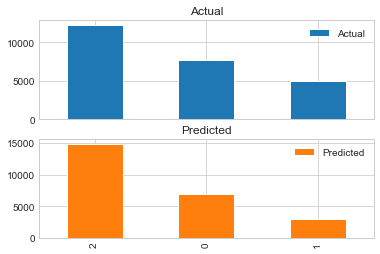

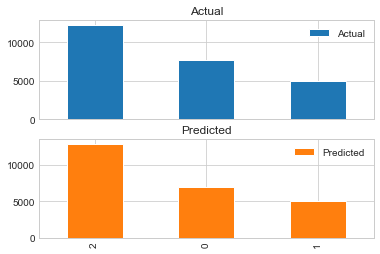

In [49]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim =1
    else:
        trainX_data = combination_features_X 
        dim = 2
    result = compute_MLP_Classifier(flag=1,dim=dim,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler(),verbose=1)
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - Validation_split

Epoch 1/50
1739/1739 [==============================] - 2s 1ms/step - loss: 0.7870 - accuracy: 0.5702 - val_loss: 14.5916 - val_accuracy: 0.3437
Epoch 2/50
1739/1739 [==============================] - 2s 961us/step - loss: 0.6269 - accuracy: 0.6624 - val_loss: 10.8822 - val_accuracy: 0.3437
Epoch 3/50
1739/1739 [==============================] - 2s 997us/step - loss: 0.5644 - accuracy: 0.7006 - val_loss: 10.6030 - val_accuracy: 0.3283
Epoch 4/50
1739/1739 [==============================] - 2s 898us/step - loss: 0.5308 - accuracy: 0.7175 - val_loss: 10.4772 - val_accuracy: 0.3353
Epoch 5/50
1739/1739 [==============================] - 2s 907us/step - loss: 0.5043 - accuracy: 0.7316 - val_loss: 10.5182 - val_accuracy: 0.3437
Epoch 6/50
1739/1739 [==============================] - 2s 925us/step - loss: 0.4905 - accuracy: 0.7464 - val_loss: 10.4279 - val_accuracy: 0.3418
Epoch 7/50
1739/1739 [==============================] - 2s 951us/step - loss: 0.4769 - accuracy: 0.7557 - val_loss: 12.2

<Figure size 864x432 with 0 Axes>

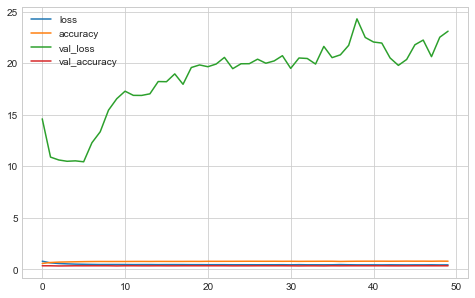

777/777 [==============================] - 1s 648us/step - loss: 7.2421 - accuracy: 0.6477


[7.242124557495117, 0.6477007269859314]

In [50]:
model = create_model(dim=2)
history = model.fit(combination_features_X,train_Y,validation_split=0.3,batch_size = 10,epochs=50,verbose=1)
plt.figure(figsize=(12,6))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
model.evaluate(combination_features_X,train_Y,verbose=1)

#### Experiment -MLP with Stratified K-Fold
Experiment using cross validation approach of StratifiedKFold

Cross Validation Activated. CV = 2
Cross Validation Activated. CV = 3
Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5
Cross Validation Activated. CV = 2
Cross Validation Activated. CV = 3
Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5
Cross Validation Activated. CV = 2
Cross Validation Activated. CV = 3
Cross Validation Activated. CV = 4
Cross Validation Activated. CV = 5


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,folds,type
2,0.535637,0.535637,0.731872,0.421492,0.464363,0.419520,0.464363,0.464363,0.464363,0.401228,0.396488,0.397952,0.459678,0.464363,0.460950,4,RSSI Only
10,0.536603,0.536603,0.732532,0.417123,0.463397,0.418407,0.463397,0.463397,0.463397,0.395923,0.398397,0.396950,0.455650,0.463397,0.459245,4,Both
11,0.537932,0.537932,0.733438,0.397373,0.462068,0.406368,0.462068,0.462068,0.462068,0.372180,0.393190,0.382252,0.433448,0.462068,0.447131,5,Both
3,0.539502,0.539502,0.734508,0.392093,0.460498,0.403320,0.460498,0.460498,0.460498,0.366124,0.392880,0.379007,0.427567,0.460498,0.443394,5,RSSI Only
6,0.576025,0.576025,0.758963,0.378374,0.423975,0.377742,0.423975,0.423975,0.423975,0.358034,0.356818,0.356223,0.414129,0.423975,0.417583,4,Rolling Mean RSSI
7,0.610896,0.610896,0.781599,0.332781,0.389104,0.338748,0.389104,0.389104,0.389104,0.310771,0.324773,0.316942,0.364499,0.389104,0.375615,5,Rolling Mean RSSI
0,0.647942,0.647942,0.804949,0.198919,0.352058,0.229186,0.352058,0.352058,0.352058,0.153596,0.238138,0.186744,0.227073,0.352058,0.276079,2,RSSI Only
8,0.674358,0.674358,0.821193,0.193622,0.325642,0.218905,0.325642,0.325642,0.325642,0.152617,0.220270,0.180306,0.225625,0.325642,0.266560,2,Both
4,0.719055,0.719055,0.847971,0.185153,0.280945,0.200761,0.280945,0.280945,0.280945,0.151499,0.190036,0.168594,0.223973,0.280945,0.249245,2,Rolling Mean RSSI
9,0.707417,0.707417,0.841081,0.162926,0.292583,0.188688,0.292583,0.292583,0.292583,0.125032,0.197908,0.153247,0.184845,0.292583,0.226557,3,Both


Number of Folds:  4


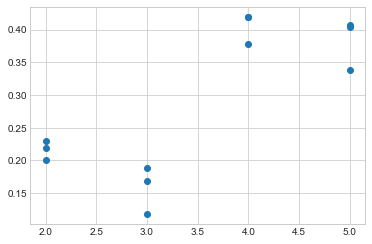

In [51]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X 
        dim = 2
    for cv in cross_validation_list:
        result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,testY_data=train_Y.ravel(),epochs=25,
                                   scaler=StandardScaler(),cross_validation=cv)
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - MLP with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,test_size,type
18,0.209340,0.209340,0.457537,0.785495,0.790660,0.776474,0.790660,0.790660,0.790660,0.782412,0.759780,0.769531,0.792662,0.790660,0.790061,0.1,Both
24,0.232225,0.232225,0.481897,0.760335,0.767775,0.753041,0.767775,0.767775,0.767775,0.755770,0.737924,0.745590,0.771156,0.767775,0.768113,0.7,Both
19,0.228709,0.228709,0.478236,0.773137,0.771291,0.751832,0.771291,0.771291,0.771291,0.772772,0.725139,0.742880,0.776444,0.771291,0.768181,0.2,Both
22,0.234115,0.234115,0.483854,0.764727,0.765885,0.747721,0.765885,0.765885,0.765885,0.762713,0.724081,0.739031,0.771622,0.765885,0.764313,0.5,Both
20,0.230305,0.230305,0.479901,0.772491,0.769695,0.747660,0.769695,0.769695,0.769695,0.772484,0.718475,0.737697,0.775315,0.769695,0.765479,0.3,Both
21,0.231729,0.231729,0.481383,0.767481,0.768271,0.746861,0.768271,0.768271,0.768271,0.765986,0.719863,0.736991,0.772667,0.768271,0.764935,0.4,Both
25,0.234699,0.234699,0.484457,0.762149,0.765301,0.745256,0.765301,0.765301,0.765301,0.759562,0.720804,0.735802,0.769348,0.765301,0.763027,0.8,Both
23,0.243608,0.243608,0.493566,0.749940,0.756392,0.742759,0.756392,0.756392,0.756392,0.745854,0.728377,0.735853,0.759828,0.756392,0.756751,0.6,Both
0,0.281804,0.281804,0.530852,0.723203,0.718196,0.688476,0.718196,0.718196,0.718196,0.723399,0.654500,0.675488,0.727429,0.718196,0.710704,0.1,RSSI Only
4,0.286784,0.286784,0.535522,0.727246,0.713216,0.685119,0.713216,0.713216,0.713216,0.728681,0.649451,0.672460,0.735535,0.713216,0.707661,0.5,RSSI Only


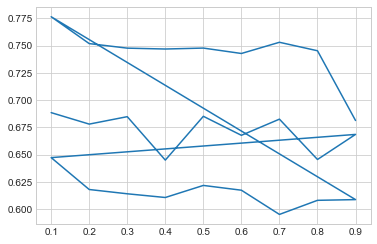

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### Experiment - MLP with LOGO
Experiment using cross validation approach of Leave One Group Out

In [53]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    loo.append(scannedType)
    results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x00000163021B1200>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x00000163021B1BA0>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x0000016302C8F350>


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using MLP

Epoch 1/25
1739/1739 [==============================] - 2s 871us/step - loss: 0.7188 - accuracy: 0.65550s - loss: 0.7240 - accuracy
Epoch 2/25
1739/1739 [==============================] - 2s 871us/step - loss: 0.6767 - accuracy: 0.67690s -
Epoch 3/25
1739/1739 [==============================] - 1s 853us/step - loss: 0.6599 - accuracy: 0.69151s - loss: 0.6557 - accuracy:  - ETA: 1s - loss: 0.6615 - accu - ETA: 0s - loss: 0.664
Epoch 4/25
1739/1739 [==============================] - 1s 862us/step - loss: 0.6522 - accuracy: 0.70140s - loss: 0.6515 - accuracy: 0.
Epoch 5/25
1739/1739 [==============================] - 2s 871us/step - loss: 0.6466 - accuracy: 0.7031
Epoch 6/25
1739/1739 [==============================] - 1s 862us/step - loss: 0.6447 - accuracy: 0.7018
Epoch 7/25
1739/1739 [==============================] - 1s 862us/step - loss: 0.6418 - accuracy: 0.70340s - loss: 0.6421 - accuracy: 0.
Epoch 8/25
1739/1739 [==============================] - 1s 853us/step - loss: 0.6420 - acc

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,method,type
7,0.235136,0.235136,0.484908,0.759123,0.764864,0.752147,0.764864,0.764864,0.764864,0.754901,0.738895,0.745485,0.770269,0.764864,0.766080,HoldOut,Both
1,0.285599,0.285599,0.534415,0.728348,0.714401,0.685288,0.714401,0.714401,0.714401,0.729929,0.648937,0.672299,0.735970,0.714401,0.708131,HoldOut,RSSI Only
4,0.338478,0.338478,0.581789,0.704517,0.661522,0.608225,0.661522,0.661522,0.661522,0.713632,0.564826,0.587487,0.711052,0.661522,0.637879,HoldOut,Rolling Mean RSSI
2,0.503221,0.503221,0.709381,0.416614,0.496779,0.423186,0.496779,0.496779,0.496779,0.387550,0.406817,0.393226,0.452707,0.496779,0.469433,Stratified K-Fold,RSSI Only
8,0.523879,0.523879,0.723795,0.411761,0.476121,0.421039,0.476121,0.476121,0.476121,0.386464,0.408318,0.397052,0.448591,0.476121,0.461902,Stratified K-Fold,Both
5,0.620279,0.620279,0.787578,0.328334,0.379721,0.333300,0.379721,0.379721,0.379721,0.307744,0.319211,0.312862,0.359305,0.379721,0.368634,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


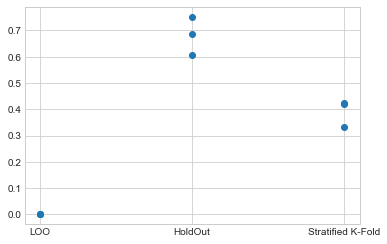

In [54]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
    holdout = compute_MLP_Classifier(verbose=1,dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited) 
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_MLP_Classifier(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = 5)  
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,preprocessing,preprocessingFunc,type
8,0.223326,0.223326,0.472574,0.774942,0.776674,0.764282,0.776674,0.776674,0.776674,0.772398,0.748224,0.757892,0.783383,0.776674,0.777447,StandardScaler,StandardScaler(),Both
10,0.256610,0.256610,0.506567,0.769926,0.743390,0.715658,0.743390,0.743390,0.743390,0.777258,0.675397,0.703862,0.767134,0.743390,0.735110,MinMaxScaler,MinMaxScaler(),Both
0,0.289089,0.289089,0.537670,0.700448,0.710911,0.691133,0.710911,0.710911,0.710911,0.695119,0.672129,0.681677,0.711299,0.710911,0.709180,StandardScaler,StandardScaler(),RSSI Only
2,0.290028,0.290028,0.538543,0.737502,0.709972,0.665048,0.709972,0.709972,0.709972,0.744272,0.621791,0.646830,0.737955,0.709972,0.693000,MinMaxScaler,MinMaxScaler(),RSSI Only
11,0.320897,0.320897,0.566477,0.697220,0.679103,0.660992,0.679103,0.679103,0.679103,0.699478,0.632940,0.652177,0.706306,0.679103,0.678142,None,None,Both
1,0.317675,0.317675,0.563627,0.739158,0.682325,0.633758,0.682325,0.682325,0.682325,0.752960,0.587338,0.614814,0.740784,0.682325,0.660968,MaxAbsScaler,MaxAbsScaler(),RSSI Only
3,0.317675,0.317675,0.563627,0.739158,0.682325,0.633758,0.682325,0.682325,0.682325,0.752960,0.587338,0.614814,0.740784,0.682325,0.660968,None,None,RSSI Only
6,0.339015,0.339015,0.582250,0.690552,0.660985,0.626692,0.660985,0.660985,0.660985,0.697276,0.587463,0.612626,0.693223,0.660985,0.648667,MinMaxScaler,MinMaxScaler(),Rolling Mean RSSI
4,0.337270,0.337270,0.580750,0.705516,0.662730,0.608768,0.662730,0.662730,0.662730,0.714890,0.565305,0.587850,0.710807,0.662730,0.638478,StandardScaler,StandardScaler(),Rolling Mean RSSI
9,0.348544,0.348544,0.590376,0.669575,0.651456,0.594291,0.651456,0.651456,0.651456,0.674818,0.559817,0.572188,0.666724,0.651456,0.625537,MaxAbsScaler,MaxAbsScaler(),Both


Selected Preprocessing:  StandardScaler


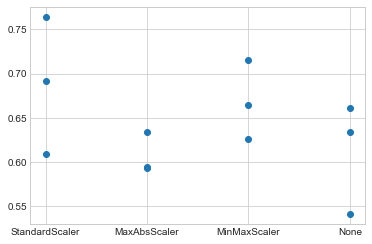

In [55]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited) 
        elif selected_method =='Stratified K-Fold':
            result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = 5)  
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment - Hyperparameter Optimization (Number of neurons per Layer)

In [56]:
statistical_cols = ['neurons','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim, epochs=15, batch_size=10, verbose=0)
    param_grid = dict(num_neurons=neurons)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['num_neurons'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_number_neurons = statistics.sort_values(by=['neurons'])['neurons'].head(1).values[0]
print("Selected Number Neurons: ",selected_number_neurons)

Best: 0.642682 using {'num_neurons': 600}
0.612805 (0.207638) with: {'num_neurons': 100}
0.592470 (0.244563) with: {'num_neurons': 300}
0.577490 (0.213298) with: {'num_neurons': 400}
0.596457 (0.213032) with: {'num_neurons': 500}
0.642682 (0.226929) with: {'num_neurons': 600}
Best: 0.628307 using {'num_neurons': 500}
0.589853 (0.214591) with: {'num_neurons': 100}
0.561144 (0.243215) with: {'num_neurons': 300}
0.588645 (0.231861) with: {'num_neurons': 400}
0.628307 (0.222468) with: {'num_neurons': 500}
0.560419 (0.257620) with: {'num_neurons': 600}
Best: 0.672962 using {'num_neurons': 300}
0.578981 (0.234362) with: {'num_neurons': 100}
0.672962 (0.202048) with: {'num_neurons': 300}
0.649607 (0.201297) with: {'num_neurons': 400}
0.615824 (0.217418) with: {'num_neurons': 500}
0.545601 (0.246504) with: {'num_neurons': 600}


,neurons,type
0,600,RSSI Only
1,500,Rolling Mean RSSI
2,300,Both


Selected Number Neurons:  300


#### Experiment -  Hyperparameter Optimization (Batch Size and Epochs)

In [57]:
statistical_cols = ['batch_size','epochs','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim, verbose=0)
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['batch_size'])
    result.append(grid_result.best_params_['epochs'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_batch_size = statistics.sort_values(by=['batch_size'])['batch_size'].head(1).values[0]
print("Selected Batch Size: ",selected_batch_size)
selected_epochs = statistics.sort_values(by=['epochs'])['epochs'].head(1).values[0]
print("Selected Epochs: ",selected_epochs)

Best: 0.732870 using {'batch_size': 10, 'epochs': 100}
0.624026 (0.279837) with: {'batch_size': 10, 'epochs': 10}
0.590451 (0.352705) with: {'batch_size': 10, 'epochs': 50}
0.732870 (0.189352) with: {'batch_size': 10, 'epochs': 100}
0.697397 (0.231040) with: {'batch_size': 20, 'epochs': 10}
0.604180 (0.241349) with: {'batch_size': 20, 'epochs': 50}
0.589889 (0.238483) with: {'batch_size': 20, 'epochs': 100}
0.464858 (0.384859) with: {'batch_size': 40, 'epochs': 10}
0.647300 (0.242449) with: {'batch_size': 40, 'epochs': 50}
0.647823 (0.242582) with: {'batch_size': 40, 'epochs': 100}
0.464851 (0.393305) with: {'batch_size': 60, 'epochs': 10}
0.518539 (0.360731) with: {'batch_size': 60, 'epochs': 50}
0.702308 (0.185317) with: {'batch_size': 60, 'epochs': 100}
0.566616 (0.377241) with: {'batch_size': 80, 'epochs': 10}
0.453622 (0.332944) with: {'batch_size': 80, 'epochs': 50}
0.632811 (0.217215) with: {'batch_size': 80, 'epochs': 100}
0.316802 (0.398665) with: {'batch_size': 100, 'epochs':

,batch_size,epochs,type
0,10,100,RSSI Only
1,60,100,Rolling Mean RSSI
2,20,100,Both


Selected Batch Size:  10
Selected Epochs:  100


#### Experiment -  Hyperparameter Optimization (Optimization Algorithm)

In [58]:
statistical_cols = ['optimization_algorithm','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50, batch_size=10, verbose=0)
    param_grid = dict(optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['optimizer'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_optimization_algorithm = statistics.sort_values(by=['optimization_algorithm'])['optimization_algorithm'].head(1).values[0]
print("Selected Optimization Algorithm: ",selected_optimization_algorithm)

Best: 0.689740 using {'optimizer': 'Adamax'}
0.494815 (0.401596) with: {'optimizer': 'SGD'}
0.633771 (0.270605) with: {'optimizer': 'RMSprop'}
0.576121 (0.369435) with: {'optimizer': 'Adagrad'}
0.523890 (0.384521) with: {'optimizer': 'Adadelta'}
0.613394 (0.273921) with: {'optimizer': 'Adam'}
0.689740 (0.236567) with: {'optimizer': 'Adamax'}
0.543101 (0.366463) with: {'optimizer': 'Nadam'}
Best: 0.703111 using {'optimizer': 'RMSprop'}
0.550352 (0.280648) with: {'optimizer': 'SGD'}
0.703111 (0.200561) with: {'optimizer': 'RMSprop'}
0.574913 (0.369565) with: {'optimizer': 'Adagrad'}
0.444799 (0.442988) with: {'optimizer': 'Adadelta'}
0.454111 (0.356295) with: {'optimizer': 'Adam'}
0.605991 (0.235357) with: {'optimizer': 'Adamax'}
0.566933 (0.255273) with: {'optimizer': 'Nadam'}
Best: 0.623187 using {'optimizer': 'Adamax'}
0.310275 (0.410197) with: {'optimizer': 'SGD'}
0.516761 (0.286833) with: {'optimizer': 'RMSprop'}
0.541931 (0.376943) with: {'optimizer': 'Adagrad'}
0.466666 (0.421670)

,optimization_algorithm,type
0,Adamax,RSSI Only
1,RMSprop,Rolling Mean RSSI
2,Adamax,Both


Selected Optimization Algorithm:  Adamax


#### Experiment -  Hyperparameter Optimization (Learning Rate and Momentum)

In [59]:
from keras.optimizers import SGD
def create_model_SGD(dim=2,learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(num_neurons_basic,input_dim=dim,activation='relu'))
    model.add(Dense(num_neurons_basic,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [60]:
statistical_cols = ['learning_rate','momentum','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model_SGD,dim=dim,epochs=50, batch_size=10, verbose=0)
    param_grid = dict(learn_rate=learn_rate, momentum=momentum)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['learn_rate'])
    result.append(grid_result.best_params_['momentum'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_learning_rate = statistics.sort_values(by=['learning_rate'])['learning_rate'].head(1).values[0]
print("Selected Learing Rate: ",selected_learning_rate)
selected_momentum = statistics.sort_values(by=['momentum'])['momentum'].head(1).values[0]
print("Selected Momentum: ",selected_momentum)

Best: 0.689725 using {'learn_rate': 0.3, 'momentum': 0.2}
0.509150 (0.403407) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.497961 (0.367858) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.578860 (0.368260) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.561864 (0.377369) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.519465 (0.361212) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.480443 (0.302199) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.592656 (0.307435) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.551668 (0.288417) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.438235 (0.446855) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.403280 (0.405005) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.439725 (0.447911) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.439725 (0.447911) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.439725 (0.447911) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.439725 (0.447911) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.439725 (0.447911) with: {'learn_rate': 0

,learning_rate,momentum,type
0,0.30,0.2,RSSI Only
1,0.10,0.6,Rolling Mean RSSI
2,0.01,0.6,Both


Selected Learing Rate:  0.01
Selected Momentum:  0.2


#### Experiment -  Hyperparameter Optimization (Activation Function)

In [61]:
statistical_cols = ['activation_function','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,batch_size=10,verbose=0)
    param_grid = dict(activation=activation)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_['activation'])
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
selected_activation_function = statistics.sort_values(by=['activation_function'])['activation_function'].head(1).values[0]
print("Selected Activation Function: ",selected_activation_function)

Best: 0.683426 using {'activation': 'tanh'}
0.496779 (0.358808) with: {'activation': 'softmax'}
0.632844 (0.247338) with: {'activation': 'softplus'}
0.617751 (0.223145) with: {'activation': 'softsign'}
0.491758 (0.365731) with: {'activation': 'relu'}
0.683426 (0.182862) with: {'activation': 'tanh'}
0.669814 (0.197059) with: {'activation': 'sigmoid'}
0.645580 (0.212488) with: {'activation': 'hard_sigmoid'}
0.551470 (0.264073) with: {'activation': 'linear'}
Best: 0.654267 using {'activation': 'softplus'}
0.486391 (0.353816) with: {'activation': 'softmax'}
0.654267 (0.224245) with: {'activation': 'softplus'}
0.550786 (0.265729) with: {'activation': 'softsign'}
0.471300 (0.367751) with: {'activation': 'relu'}
0.598135 (0.278110) with: {'activation': 'tanh'}
0.549854 (0.296767) with: {'activation': 'sigmoid'}
0.535080 (0.282119) with: {'activation': 'hard_sigmoid'}
0.581910 (0.258317) with: {'activation': 'linear'}
Best: 0.668765 using {'activation': 'softsign'}
0.422934 (0.436751) with: {'

,activation_function,type
0,tanh,RSSI Only
1,softplus,Rolling Mean RSSI
2,softsign,Both


Selected Activation Function:  softplus


### Run RandomSearchCV for parameter tunning

In [ ]:
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for feature in types:
    result = list()
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,batch_size=10,verbose=0)
    param_grid = dict(activation=activation,optimizer=optimizer,num_neurons=neurons)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=45, n_jobs=1, cv=selected_fold)
    grid_result = grid.fit(trainX_data, train_Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    result.append(grid_result.best_params_)
    result.append(feature)
    results.append(result)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

### Best Parameters
Display the best parameters tunned throughout the experiments

In [82]:
conclusion_cols=['Cross_Validation','Number of Neurons','Activation Function','Batch Size','Epochs','Optimizer','Learning Rate',
                 'Momentum','Preprocessing']
conclusion_list = [selected_method,selected_number_neurons,selected_activation_function,selected_batch_size,selected_epochs,
                   selected_optimization_algorithm,selected_learning_rate,selected_momentum,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,Cross_Validation,Number of Neurons,Activation Function,Batch Size,Epochs,Optimizer,Learning Rate,Momentum,Preprocessing
0,HoldOut,300,softplus,10,100,Adamax,0.01,0.2,StandardScaler


### Best Results
Compute MLP with the best parameters

In [83]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
final_results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
        loo = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=selected_epochs,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_Classifier(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = 5,
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm)   
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
        result = compute_MLP_Classifier(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler(),
                                    num_neurons_param=selected_number_neurons,activation_func=selected_activation_function,
                                    batch_size=selected_batch_size,optimizer_func=selected_optimization_algorithm) 
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending = False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type
2,0.341296,0.341296,0.584206,0.701497,0.658704,0.616560,0.658704,0.658704,0.658704,0.711632,0.574227,0.599945,0.703746,0.658704,0.640879,Both
1,0.349349,0.349349,0.591058,0.719185,0.650651,0.557910,0.650651,0.650651,0.650651,0.735738,0.522056,0.524160,0.721510,0.650651,0.600170,Rolling Mean RSSI
0,0.341565,0.341565,0.584436,0.729575,0.658435,0.545206,0.658435,0.658435,0.658435,0.747361,0.519195,0.504512,0.729571,0.658435,0.594750,RSSI Only


### Best Results - Testing data (Different Beacon)
Experiment with testing dataset

In [84]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model_test(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = create_model_test()
display(model.summary())

Default number of neurons: 180
Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_732 (Dense)            (None, 180)               540       
_________________________________________________________________
dense_733 (Dense)            (None, 180)               32580     
_________________________________________________________________
dense_734 (Dense)            (None, 4)                 724       
Total params: 33,844
Trainable params: 33,844
Non-trainable params: 0
_________________________________________________________________


None

Confusion Matrix:
[[ 986   69   56]
 [   0    7  704]
 [ 462   79 1314]]


,precision,recall,f1-score,support
0,0.680939,0.887489,0.770614,1111.000000
1,0.045161,0.009845,0.016166,711.000000
2,0.633558,0.708356,0.668872,1855.000000
accuracy,0.627414,0.627414,0.627414,0.627414
macro avg,0.453220,0.535230,0.485217,3677.000000
weighted avg,0.534100,0.627414,0.573403,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,1
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 1ms/step - loss: 1.0408 - accuracy: 0.4884
Confusion Matrix:
[[   0    0 1111]
 [   0    0  711]
 [   0    0 1855]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.000000,0.000000,0.000000,711.000000
2,0.504487,1.000000,0.670644,1855.000000
accuracy,0.504487,0.504487,0.504487,0.504487
macro avg,0.168162,0.333333,0.223548,3677.000000
weighted avg,0.254507,0.504487,0.338331,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


Confusion Matrix:
[[ 943   12  156]
 [   0    0  711]
 [ 122    0 1733]]


,precision,recall,f1-score,support
0,0.885446,0.848785,0.866728,1111.000000
1,0.000000,0.000000,0.000000,711.000000
2,0.666538,0.934232,0.778002,1855.000000
accuracy,0.727767,0.727767,0.727767,0.727767
macro avg,0.517328,0.594339,0.548243,3677.000000
weighted avg,0.603796,0.727767,0.654373,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 1ms/step - loss: 1.0421 - accuracy: 0.4863
Confusion Matrix:
[[  0 134 977]
 [  0 694  17]
 [  0 908 947]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.399770,0.976090,0.567225,711.000000
2,0.487893,0.510512,0.498946,1855.000000
accuracy,0.446288,0.446288,0.446288,0.446288
macro avg,0.295887,0.495534,0.355390,3677.000000
weighted avg,0.323437,0.446288,0.361393,3677.000000


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


Confusion Matrix:
[[ 952   45  114]
 [   0    0  711]
 [ 231   27 1597]]


,precision,recall,f1-score,support
0,0.804734,0.856886,0.829991,1111.000000
1,0.000000,0.000000,0.000000,711.000000
2,0.659372,0.860916,0.746785,1855.000000
accuracy,0.693228,0.693228,0.693228,0.693228
macro avg,0.488035,0.572601,0.525592,3677.000000
weighted avg,0.575794,0.693228,0.627524,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


777/777 [==============================] - 1s 952us/step - loss: 1.0476 - accuracy: 0.4832
Confusion Matrix:
[[   0  133  978]
 [   0  618   93]
 [   0  748 1107]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.412275,0.869198,0.559276,711.000000
2,0.508264,0.596765,0.548971,1855.000000
accuracy,0.469132,0.469132,0.469132,0.469132
macro avg,0.306846,0.488655,0.369416,3677.000000
weighted avg,0.336132,0.469132,0.385093,3677.000000


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
2,0.272233,0.272233,0.521759,0.566813,0.727767,0.595852,0.727767,0.727767,0.727767,0.517328,0.594339,0.548243,0.603796,0.727767,0.654373,Rolling Mean RSSI,True
4,0.306772,0.306772,0.553870,0.536861,0.693228,0.570520,0.693228,0.693228,0.693228,0.488035,0.572601,0.525592,0.575794,0.693228,0.627524,Both,True
0,0.372586,0.372586,0.610399,0.495732,0.627414,0.523614,0.627414,0.627414,0.627414,0.453220,0.535230,0.485217,0.534100,0.627414,0.573403,RSSI Only,True
5,0.530868,0.530868,0.728607,0.338775,0.469132,0.388648,0.469132,0.469132,0.469132,0.306846,0.488655,0.369416,0.336132,0.469132,0.385093,Both,False
3,0.553712,0.553712,0.744118,0.325546,0.446288,0.371540,0.446288,0.446288,0.446288,0.295887,0.495534,0.355390,0.323437,0.446288,0.361393,Rolling Mean RSSI,False
1,0.495513,0.495513,0.703927,0.238607,0.504487,0.289502,0.504487,0.504487,0.504487,0.168162,0.333333,0.223548,0.254507,0.504487,0.338331,RSSI Only,False


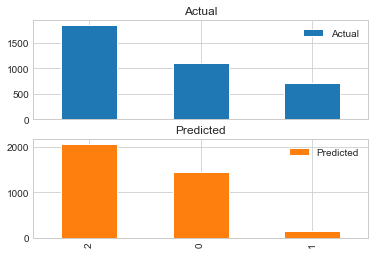

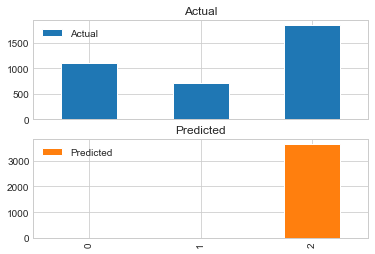

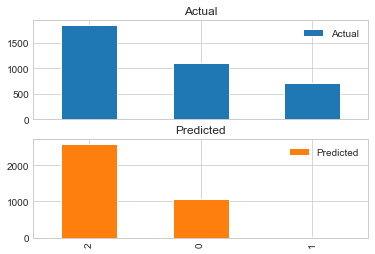

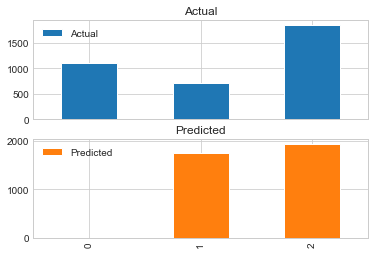

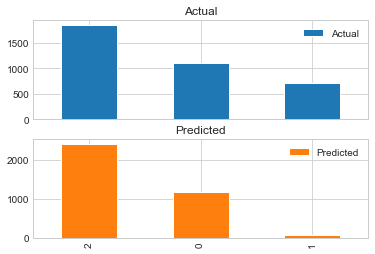

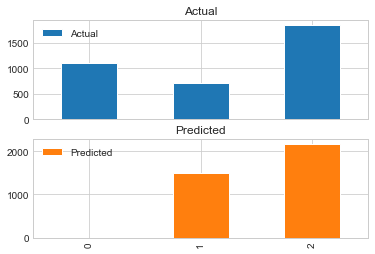

In [85]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
dim = 2
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,epochs=50,
                                                             num_neurons=selected_number_neurons,
                                                             optimizer=selected_optimization_algorithm,
                                                             activation=selected_activation_function,
                                                             batch_size=10,verbose=0)
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y)
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 BIG Dataset)
Experiment with testing dataset

Confusion Matrix:
[[4104    0  691]
 [   0    0    0]
 [1038  977 5665]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.798133,0.855892,0.826004,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.891284,0.737630,0.807210,7680.000000
accuracy,0.783086,0.783086,0.783086,0.783086
macro avg,0.563139,0.531174,0.544405,12475.000000
weighted avg,0.855480,0.783086,0.814434,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 963us/step - loss: 1.0445 - accuracy: 0.4859
Confusion Matrix:
[[   0    0 4795]
 [   0    0    0]
 [   0 5436 2244]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.00000
1,0.000000,0.000000,0.000000,0.00000
2,0.318795,0.292187,0.304912,7680.00000
accuracy,0.179880,0.179880,0.179880,0.17988
macro avg,0.106265,0.097396,0.101637,12475.00000
weighted avg,0.196260,0.179880,0.187713,12475.00000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


Confusion Matrix:
[[3809    0  986]
 [   0    0    0]
 [ 346 1131 6203]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.916727,0.794369,0.851173,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.862846,0.807682,0.834353,7680.000000
accuracy,0.802565,0.802565,0.802565,0.802565
macro avg,0.593191,0.534017,0.561842,12475.000000
weighted avg,0.883556,0.802565,0.840818,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0426 - accuracy: 0.4867
Confusion Matrix:
[[   0  177 4618]
 [   0    0    0]
 [1073 5108 1499]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.00000
1,0.000000,0.000000,0.000000,0.00000
2,0.245055,0.195182,0.217294,7680.00000
accuracy,0.120160,0.120160,0.120160,0.12016
macro avg,0.081685,0.065061,0.072431,12475.00000
weighted avg,0.150863,0.120160,0.133773,12475.00000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


Confusion Matrix:
[[4052    0  743]
 [   0    0    0]
 [ 580 1239 5861]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.874784,0.845047,0.859658,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.887492,0.763151,0.820638,7680.000000
accuracy,0.794629,0.794629,0.794629,0.794629
macro avg,0.587426,0.536066,0.560099,12475.000000
weighted avg,0.882608,0.794629,0.835637,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


777/777 [==============================] - 1s 905us/step - loss: 1.0482 - accuracy: 0.4865
Confusion Matrix:
[[   0 1135 3660]
 [   0    0    0]
 [   0 7680    0]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.0,0.0,0.0,4795.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,7680.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,12475.0
weighted avg,0.0,0.0,0.0,12475.0


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
2,0.197435,0.197435,0.444336,0.676481,0.802565,0.648459,0.802565,0.802565,0.802565,0.593191,0.534017,0.561842,0.883556,0.802565,0.840818,Rolling Mean RSSI,True
4,0.205371,0.205371,0.453178,0.671157,0.794629,0.645110,0.794629,0.794629,0.794629,0.587426,0.536066,0.560099,0.882608,0.794629,0.835637,Both,True
0,0.216914,0.216914,0.465740,0.648520,0.783086,0.629190,0.783086,0.783086,0.783086,0.563139,0.531174,0.544405,0.855480,0.783086,0.814434,RSSI Only,True
1,0.820120,0.820120,0.905605,0.133533,0.179880,0.129024,0.179880,0.179880,0.179880,0.106265,0.097396,0.101637,0.196260,0.179880,0.187713,RSSI Only,False
3,0.879840,0.879840,0.937998,0.099627,0.120160,0.090610,0.120160,0.120160,0.120160,0.081685,0.065061,0.072431,0.150863,0.120160,0.133773,Rolling Mean RSSI,False
5,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Both,False


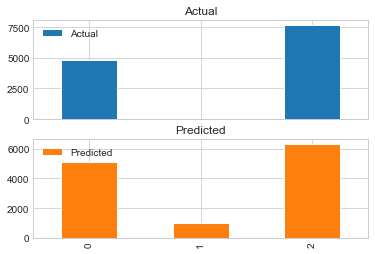

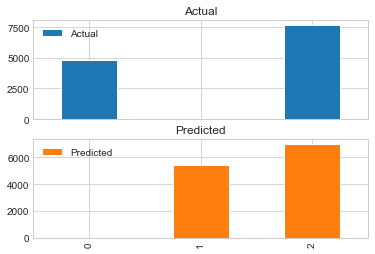

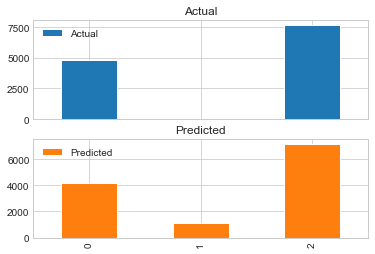

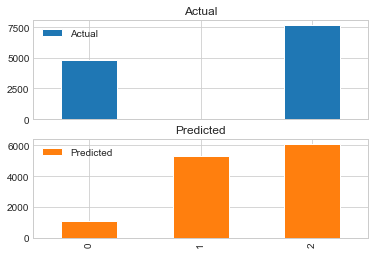

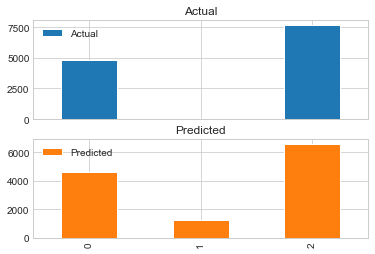

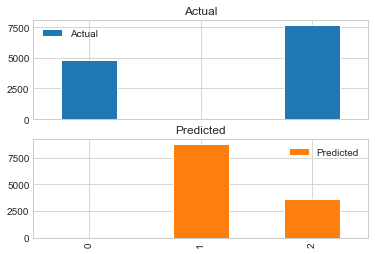

In [86]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_big
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_big
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_big
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)  
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_big.ravel(), predicted)
        report = classification_report(test_Y_home_big.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_big.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_big.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 Small Dataset)
Experiment with testing dataset

Confusion Matrix:
[[ 515   43  299]
 [   0    0    0]
 [ 184  134 1109]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.736767,0.600933,0.661954,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.787642,0.777155,0.782363,1427.000000
accuracy,0.711033,0.711033,0.711033,0.711033
macro avg,0.508136,0.459363,0.481439,2284.000000
weighted avg,0.768553,0.711033,0.737183,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,1


777/777 [==============================] - 1s 960us/step - loss: 1.0432 - accuracy: 0.4921
Confusion Matrix:
[[  0  80 777]
 [  0   0   0]
 [  0 489 938]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.546939,0.657323,0.597072,1427.000000
accuracy,0.410683,0.410683,0.410683,0.410683
macro avg,0.182313,0.219108,0.199024,2284.000000
weighted avg,0.341717,0.410683,0.373039,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


Confusion Matrix:
[[ 497   28  332]
 [   0    0    0]
 [  58  141 1228]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.895495,0.579930,0.703966,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.787179,0.860547,0.822230,1427.000000
accuracy,0.755254,0.755254,0.755254,0.755254
macro avg,0.560892,0.480159,0.508732,2284.000000
weighted avg,0.827822,0.755254,0.777855,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


777/777 [==============================] - 1s 966us/step - loss: 1.0446 - accuracy: 0.4850
Confusion Matrix:
[[   0  857]
 [   0 1427]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
2,0.624781,1.000000,0.769065,1427.000000
accuracy,0.624781,0.624781,0.624781,0.624781
macro avg,0.312391,0.500000,0.384532,2284.000000
weighted avg,0.390351,0.624781,0.480497,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


Confusion Matrix:
[[ 498   30  329]
 [   0    0    0]
 [  56  114 1257]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.898917,0.581097,0.705882,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.792560,0.880869,0.834384,1427.000000
accuracy,0.768389,0.768389,0.768389,0.768389
macro avg,0.563826,0.487322,0.513422,2284.000000
weighted avg,0.832467,0.768389,0.786168,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,1


777/777 [==============================] - 1s 1ms/step - loss: 1.0447 - accuracy: 0.4870
Confusion Matrix:
[[ 35 237 585]
 [  0   0   0]
 [111 789 527]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.239726,0.040840,0.069791,857.00000
1,0.000000,0.000000,0.000000,0.00000
2,0.473921,0.369306,0.415124,1427.00000
accuracy,0.246060,0.246060,0.246060,0.24606
macro avg,0.237882,0.136715,0.161638,2284.00000
weighted avg,0.386047,0.246060,0.285548,2284.00000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,0


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
4,0.231611,0.231611,0.481260,0.642693,0.768389,0.601374,0.768389,0.768389,0.768389,0.563826,0.487322,0.513422,0.832467,0.768389,0.786168,Both,True
2,0.244746,0.244746,0.494718,0.637774,0.755254,0.594673,0.755254,0.755254,0.755254,0.560892,0.480159,0.508732,0.827822,0.755254,0.777855,Rolling Mean RSSI,True
0,0.288967,0.288967,0.537556,0.585355,0.711033,0.562329,0.711033,0.711033,0.711033,0.508136,0.459363,0.481439,0.768553,0.711033,0.737183,RSSI Only,True
3,0.375219,0.375219,0.612551,0.390461,0.624781,0.451775,0.624781,0.624781,0.624781,0.312391,0.500000,0.384532,0.390351,0.624781,0.480497,Rolling Mean RSSI,False
1,0.589317,0.589317,0.767670,0.246942,0.410683,0.263303,0.410683,0.410683,0.410683,0.182313,0.219108,0.199024,0.341717,0.410683,0.373039,RSSI Only,False
5,0.753940,0.753940,0.868297,0.263939,0.246060,0.196360,0.246060,0.246060,0.246060,0.237882,0.136715,0.161638,0.386047,0.246060,0.285548,Both,False


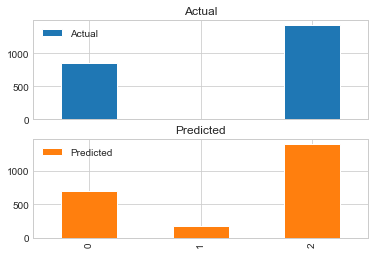

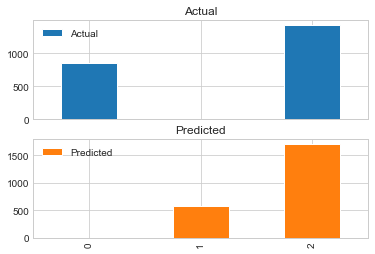

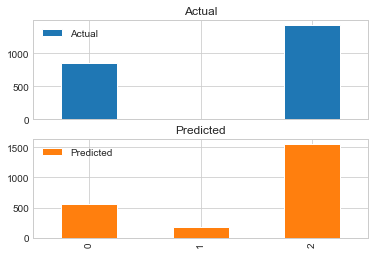

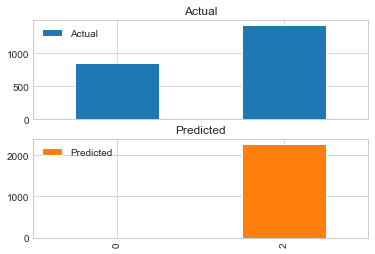

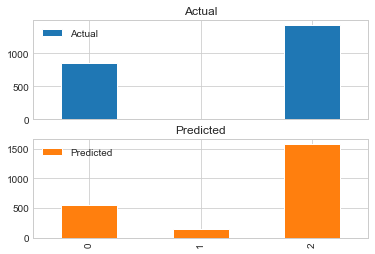

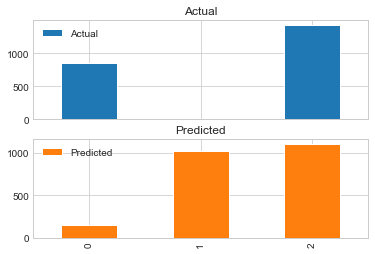

In [87]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_small
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_small
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_small
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)   
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_small.ravel(), predicted)
        report = classification_report(test_Y_home_small.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_small.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_small.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from ASUS ZENFONE LIVE)
Experiment with testing dataset

Confusion Matrix:
[[ 93   2  61]
 [  0   0   0]
 [ 16  15 228]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.853211,0.596154,0.701887,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.788927,0.880309,0.832117,259.000000
accuracy,0.773494,0.773494,0.773494,0.773494
macro avg,0.547379,0.492154,0.511335,415.000000
weighted avg,0.813092,0.773494,0.783163,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


777/777 [==============================] - 1s 974us/step - loss: 1.0432 - accuracy: 0.4869
Confusion Matrix:
[[  0 156]
 [  0 259]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
2,0.624096,1.000000,0.768546,259.000000
accuracy,0.624096,0.624096,0.624096,0.624096
macro avg,0.312048,0.500000,0.384273,415.000000
weighted avg,0.389496,0.624096,0.479647,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


Confusion Matrix:
[[100   0  56]
 [  0   0   0]
 [  0   2 257]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,0.641026,0.781250,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.821086,0.992278,0.898601,259.000000
accuracy,0.860241,0.860241,0.860241,0.860241
macro avg,0.607029,0.544435,0.559950,415.000000
weighted avg,0.888341,0.860241,0.854489,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


777/777 [==============================] - 1s 905us/step - loss: 1.0427 - accuracy: 0.4858
Confusion Matrix:
[[  0  31 125]
 [  0   0   0]
 [  0 183  76]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.378109,0.293436,0.330435,259.000000
accuracy,0.183133,0.183133,0.183133,0.183133
macro avg,0.126036,0.097812,0.110145,415.000000
weighted avg,0.235977,0.183133,0.206223,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,1
411,2,1
412,2,1
413,2,1


Confusion Matrix:
[[100   0  56]
 [  0   0   0]
 [  0   5 254]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,0.641026,0.781250,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.819355,0.980695,0.892794,259.000000
accuracy,0.853012,0.853012,0.853012,0.853012
macro avg,0.606452,0.540574,0.558015,415.000000
weighted avg,0.887260,0.853012,0.850864,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


777/777 [==============================] - 1s 1ms/step - loss: 1.0428 - accuracy: 0.4856
Confusion Matrix:
[[  0 156]
 [  0 259]]


C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
2,0.624096,1.000000,0.768546,259.000000
accuracy,0.624096,0.624096,0.624096,0.624096
macro avg,0.312048,0.500000,0.384273,415.000000
weighted avg,0.389496,0.624096,0.479647,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
2,0.139759,0.139759,0.373844,0.696116,0.860241,0.659089,0.860241,0.860241,0.860241,0.607029,0.544435,0.559950,0.888341,0.860241,0.854489,Rolling Mean RSSI,True
4,0.146988,0.146988,0.383390,0.694346,0.853012,0.655989,0.853012,0.853012,0.853012,0.606452,0.540574,0.558015,0.887260,0.853012,0.850864,Both,True
0,0.226506,0.226506,0.475926,0.629351,0.773494,0.600332,0.773494,0.773494,0.773494,0.547379,0.492154,0.511335,0.813092,0.773494,0.783163,RSSI Only,True
1,0.375904,0.375904,0.613110,0.389947,0.624096,0.451312,0.624096,0.624096,0.624096,0.312048,0.500000,0.384273,0.389496,0.624096,0.479647,RSSI Only,False
5,0.375904,0.375904,0.613110,0.389947,0.624096,0.451312,0.624096,0.624096,0.624096,0.312048,0.500000,0.384273,0.389496,0.624096,0.479647,Both,False
3,0.816867,0.816867,0.903807,0.153876,0.183133,0.138323,0.183133,0.183133,0.183133,0.126036,0.097812,0.110145,0.235977,0.183133,0.206223,Rolling Mean RSSI,False


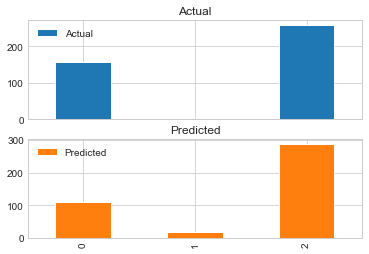

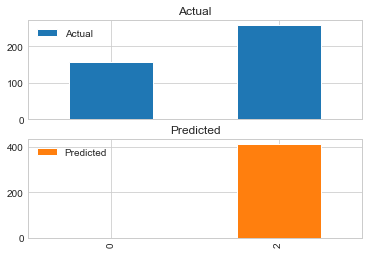

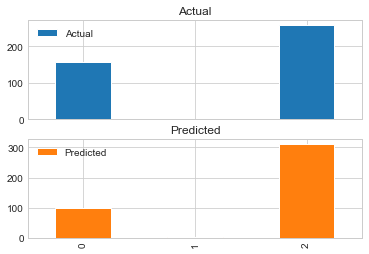

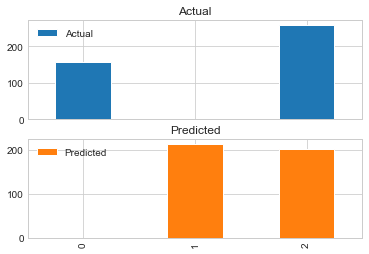

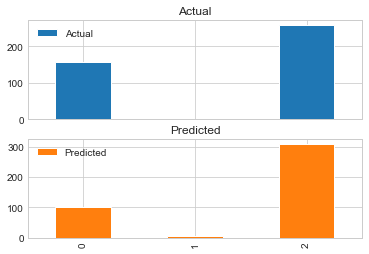

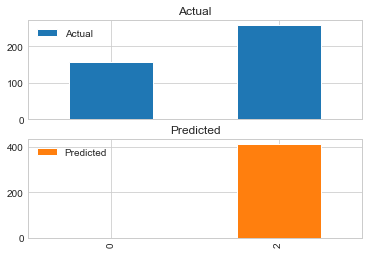

In [88]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
results = list()
tuning =[True,False]
dim = 2
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_asus
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_asus
        dim = 1
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_asus
        dim = 2
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    seed = 7
    np.random.seed(seed)
    for tune in tuning:
        if tune == True:
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim,
                                                        num_neurons=selected_number_neurons,activation=selected_activation_function,
                                        batch_size=10,epochs=50,optimizer=selected_optimization_algorithm,verbose=0)  
        else: 
            keras_classification_model = KerasClassifier(build_fn=create_model,dim=dim)
        trainX_data = scaler.transform(trainX_data)
        keras_classification_model.fit(trainX_data,train_Y.ravel())
        predicted = keras_classification_model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_asus.ravel(), predicted)
        report = classification_report(test_Y_home_asus.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_asus.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_asus.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean(),statistics)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Results Display

In [89]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score',
                    'micro precision', 'micro recall', 'micro f1-score',
                    'macro precision', 'macro recall', 'macro f1-score',
                    'weighted precision', 'weighted recall', 'weighted f1-score',
                    'type','Tuning']
types = ['University Training Dataset Score','Different Beacon Score','Different Environment Score','Different Environment Score Small dataset',
        "Different Smartphone used for scanning"]
final_results.pop(1)
results = pd.DataFrame(data=final_results,columns=statistical_cols)
display(results.sort_values(by=['f1-score'],ascending=False))
# plt.figure(figsize=(20,5))
# plt.plot(types,results['f1-score'],color='green',label='Score Line')
# plt.hlines(0.6,0,5,color='red',label='Score Threshold',linestyles='dashed')
# plt.xlabel('Benchmark')
# plt.ylabel('F1-Score')
# plt.legend(loc='upper right');
# plt.show()

,mae,mse,rmse,precision,accuracy,f1-score,micro precision,micro recall,micro f1-score,macro precision,macro recall,macro f1-score,weighted precision,weighted recall,weighted f1-score,type,Tuning
3,0.139759,0.139759,0.373844,0.696116,0.860241,0.659089,0.860241,0.860241,0.860241,0.607029,0.544435,0.559950,0.888341,0.860241,0.854489,Rolling Mean RSSI,True
1,0.197435,0.197435,0.444336,0.676481,0.802565,0.648459,0.802565,0.802565,0.802565,0.593191,0.534017,0.561842,0.883556,0.802565,0.840818,Rolling Mean RSSI,True
0,0.341296,0.341296,0.584206,0.701497,0.658704,0.616560,0.658704,0.658704,0.658704,0.711632,0.574227,0.599945,0.703746,0.658704,0.640879,Both,None
2,0.231611,0.231611,0.481260,0.642693,0.768389,0.601374,0.768389,0.768389,0.768389,0.563826,0.487322,0.513422,0.832467,0.768389,0.786168,Both,True
